E-SMILES is suggested to be processed under ```rdkit2019``` environment (rdkit version: 2019.03.2), 

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
IPythonConsole.ipython_useSVG = True
print('rdkit version:', rdkit.__version__)

from e_smiles import get_e_smiles, merge_smiles, get_edit_from_e_smiles

def draw_chemical_reaction(rxn_smi, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    d2d = rdMolDraw2D.MolDraw2DSVG(900, 200)
    d2d.drawOptions().annotationFontScale = font_scale
    d2d.DrawReaction(rxn, highlightByReactant = highlightByReactant)
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText()
    svg2 = svg.replace('svg:','')
    svg3 = SVG(svg2)
    display(svg3)

def remove_atom_mapping(smi):
    mol = Chem.MolFromSmiles(smi)
    [a.ClearProp("molAtomMapNumber") for a in mol.GetAtoms()]
    smi = Chem.MolToSmiles(mol, canonical = False)
    return smi

def kekulize_smiles(smi):
    smi = smi.replace(' ','')
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol, clearAromaticFlags = True)
    smi = Chem.MolToSmiles(mol, canonical = False, kekuleSmiles = True)
    return smi

def kekulize_mapped_rxn(mapped_rxn):
    mapped_reactants, mapped_product = mapped_rxn.split('>>')[0], mapped_rxn.split('>>')[1]
    kekulized_reactants = kekulize_smiles(mapped_reactants)
    kekulized_product = kekulize_smiles(mapped_product)

    reac_mol = Chem.MolFromSmiles(kekulized_reactants)
    prod_mol = Chem.MolFromSmiles(mapped_product)

    reac_map_a = {atom.GetIdx(): atom.GetAtomMapNum() for atom in reac_mol.GetAtoms()}
    prod_map_a = {atom.GetIdx(): atom.GetAtomMapNum() for atom in prod_mol.GetAtoms()}
    max_atom_num = max(prod_map_a.values())

    for atom in reac_mol.GetAtoms():
        if not atom.GetAtomMapNum():
            max_atom_num += 1
            atom.SetAtomMapNum(max_atom_num)
            
    Chem.Kekulize(reac_mol, clearAromaticFlags = True)
    Chem.Kekulize(prod_mol, clearAromaticFlags = True)

    kekulized_reactants = Chem.MolToSmiles(reac_mol, canonical = False, kekuleSmiles = True)
    kekulized_product = Chem.MolToSmiles(prod_mol, canonical = False, kekuleSmiles = True)

    kekulized_mapped_rxn = kekulized_reactants + ">>" + kekulized_product
    return kekulized_mapped_rxn

### 1. Get E-SMILES

**For mapped reactions:**
- The reactions in ```USPTO_50k``` and ```USPTO_MIT``` have been annotated with atom mapping tags. 

- We can directly transform the ```mapped_rxns``` into ```E-SMILES``` format. (assuming the atom mappings are correct)

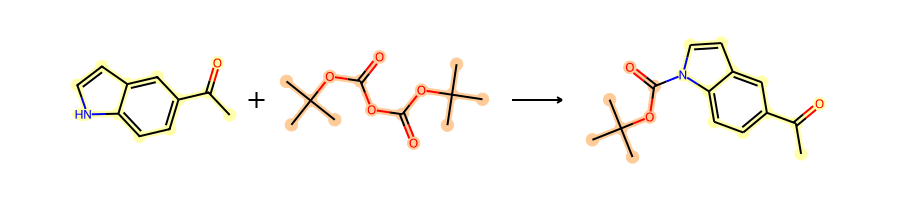

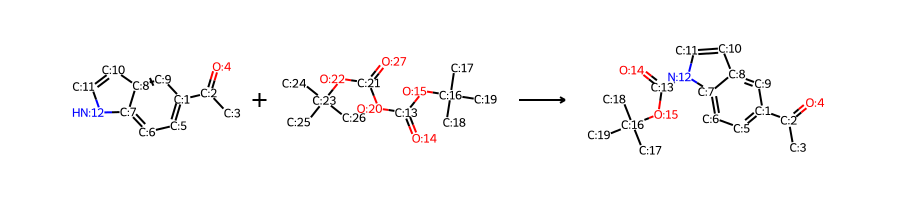

In [3]:
mapped_rxn = '[CH:5]1=[C:1]([C:2]([CH3:3])=[O:4])[CH:9]=[C:8]2[C:7](=[CH:6]1)[NH:12][CH:11]=[CH:10]2.[O:20]([C:21]([O:22][C:23]([CH3:24])([CH3:26])[CH3:25])=[O:27])[C:13](=[O:14])[O:15][C:16]([CH3:17])([CH3:18])[CH3:19]>>[C:1]1([C:2]([CH3:3])=[O:4])=[CH:5][CH:6]=[C:7]2[C:8](=[CH:9]1)[CH:10]=[CH:11][N:12]2[C:13](=[O:14])[O:15][C:16]([CH3:17])([CH3:18])[CH3:19]'
draw_chemical_reaction(mapped_rxn, highlightByReactant = True)
draw_chemical_reaction(mapped_rxn, highlightByReactant = False)

In [4]:
mapped_reactants, mapped_product = mapped_rxn.split('>>')[0], mapped_rxn.split('>>')[1]
kekulized_reactants = kekulize_smiles(remove_atom_mapping(mapped_reactants))
kekulized_product = kekulize_smiles(remove_atom_mapping(mapped_product))
e_smiles = get_e_smiles(mapped_rxn)

print("SMILES of Product: \n", kekulized_product)
print("E-SMILES: \n", e_smiles.split(">>>")[1])
print("E-SMILES (rxn): \n", e_smiles)

SMILES of Product: 
 C1(C(C)=O)=CC=C2C(=C1)C=CN2C(=O)OC(C)(C)C
E-SMILES: 
 C1(C(C)=O)=CC=C2C(=C1)C=CN2!C(=O)OC(C)(C)C<><C(OC(C)(C)C)(=O)[O:1]>
E-SMILES (rxn): 
 C1(C(C)=O)=CC=C2C(=C1)C=CN2C(=O)OC(C)(C)C>>>C1(C(C)=O)=CC=C2C(=C1)C=CN2!C(=O)OC(C)(C)C<><C(OC(C)(C)C)(=O)[O:1]>


### 2. Transform E-SMILES to reactant SMILES

SMILES of Reactants: 
 CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C


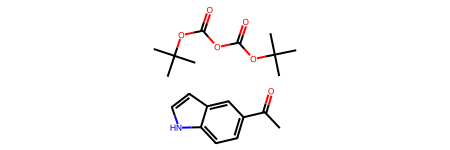

In [5]:
reactant_smiles = merge_smiles(e_smiles)
print("SMILES of Reactants: \n", reactant_smiles)
Chem.MolFromSmiles(reactant_smiles)

### 3. Example to handle unmapped reactions

**For unmapped reactions**

- We can use ```atom mapping tools``` such as [RxnMapper](https://github.com/rxn4chemistry/rxnmapper/tree/main) or [GraphormerMapper](https://github.com/chython/chytorch-rxnmap)

- Then, transform the ```mapped_rxns``` into ```E-SMILES``` format.

For Example:

In [6]:
# IBM RxnMapper: https://github.com/rxn4chemistry/rxnmapper/
# !pip install rxnmapper

Some weights of the model checkpoint at /home/zhangwei/anaconda3/envs/rdkit2019/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


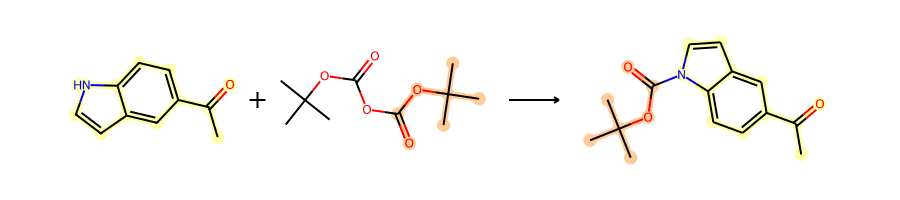

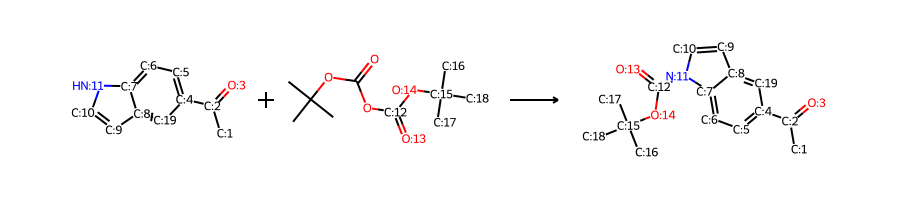

Mapped_rxn:
 [CH3:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]2[c:8]([cH:9][cH:10][nH:11]2)[cH:19]1.CC(C)(C)OC(=O)O[C:12](=[O:13])[O:14][C:15]([CH3:16])([CH3:17])[CH3:18]>>[CH3:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]2[c:8]([cH:9][cH:10][n:11]2[C:12](=[O:13])[O:14][C:15]([CH3:16])([CH3:17])[CH3:18])[cH:19]1
Confidence: 0.35

Kekulized_mapped_rxn:
 [CH3:1][C:2](=[O:3])[C:4]1=[CH:5][CH:6]=[C:7]2[C:8](=[CH:19]1)[CH:9]=[CH:10][NH:11]2.[CH3:20][C:21]([CH3:22])([CH3:23])[O:24][C:25](=[O:26])[O:27][C:12](=[O:13])[O:14][C:15]([CH3:16])([CH3:17])[CH3:18]>>[CH3:1][C:2](=[O:3])[C:4]1=[CH:5][CH:6]=[C:7]2[C:8](=[CH:19]1)[CH:9]=[CH:10][N:11]2[C:12](=[O:13])[O:14][C:15]([CH3:16])([CH3:17])[CH3:18]

SMILES of Product: 
 CC(=O)C1=CC=C2C(=C1)C=CN2C(=O)OC(C)(C)C
E-SMILES: 
 CC(=O)C1=CC=C2C(=C1)C=C!N2C(=O)OC(C)(C)C<><CC(C)(C)OC(=O)[O:1]>
E-SMILES (rxn): 
 CC(=O)C1=CC=C2C(=C1)C=CN2C(=O)OC(C)(C)C>>>CC(=O)C1=CC=C2C(=C1)C=C!N2C(=O)OC(C)(C)C<><CC(C)(C)OC(=O)[O:1]>


In [11]:
from rxnmapper import RXNMapper
rxn_mapper = RXNMapper()
rxns = ['CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C>>CC(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1']
outputs = rxn_mapper.get_attention_guided_atom_maps(rxns)

for out in outputs:
    mapped_rxn = out['mapped_rxn']
    mapped_rxn_confidence = out["confidence"]
    draw_chemical_reaction(mapped_rxn,  highlightByReactant=True)
    draw_chemical_reaction(mapped_rxn,  highlightByReactant=False)
    print("Mapped_rxn:\n", mapped_rxn)
    print(f'Confidence: {mapped_rxn_confidence:.2f}')

    mapped_reactants, mapped_product = mapped_rxn.split('>>')[0], mapped_rxn.split('>>')[1]
    kekulized_reactants = kekulize_smiles(remove_atom_mapping(mapped_reactants))
    kekulized_product = kekulize_smiles(remove_atom_mapping(mapped_product))
    kekulized_mapped_rxn = kekulize_mapped_rxn(mapped_rxn)
    e_smiles = get_e_smiles(kekulized_mapped_rxn)
    print()
    print("Kekulized_mapped_rxn:\n", kekulized_mapped_rxn)

    print()
    print("SMILES of Product: \n", kekulized_product)
    print("E-SMILES: \n", e_smiles.split(">>>")[1])
    print("E-SMILES (rxn): \n", e_smiles)